In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, plot_tree

import graphviz
import shap
import matplotlib.pyplot as plt

In [97]:
df= pd.read_csv('speed_dating_data.csv')
df

,gender,age,income,goal,career,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,0,21.0,69487.0,2.0,lawyer,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,0,21.0,69487.0,2.0,lawyer,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
2,0,21.0,69487.0,2.0,lawyer,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0
3,0,21.0,69487.0,2.0,lawyer,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,0,21.0,69487.0,2.0,lawyer,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,3.0,5.0,5.0,5.0,NaN,NaN,2.0,5.0,0.0
8374,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,6.0,8.0,4.0,4.0,NaN,4.0,4.0,0.0
8375,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,7.0,8.0,8.0,8.0,NaN,6.0,5.0,0.0
8376,1,25.0,NaN,1.0,assistant master of the universe (otherwise it...,0,4.0,6.0,5.0,4.0,NaN,5.0,5.0,5.0,0.0


In [89]:
df.columns #target: dec features: income, attr, sinc, intel, fun, amb, 

Index(['gender', 'age', 'goal', 'attr', 'sinc', 'intel', 'fun', 'amb', 'like'], dtype='object')

In [91]:
df['career'].unique()

KeyError: 'career'

In [99]:
len(df['career'].unique())

368

In [101]:
df.shape

(8378, 15)

In [103]:
df.dtypes

gender      int64
age       float64
income    float64
goal      float64
career     object
dec         int64
attr      float64
sinc      float64
intel     float64
fun       float64
amb       float64
shar      float64
like      float64
prob      float64
met       float64
dtype: object

In [105]:
df['id'] = df.set_index(['gender', 'age', 'income', 'career']).index.factorize()[0]+1

In [107]:
# dropping cols that are partner-dependent or have too many missings
df = df.drop(columns=['income', 'prob', 'shar', 'met', 'career'])

In [109]:
average_scores = df.groupby('id')[['attr', 'sinc', 'intel', 'fun', 'amb', 'like']].mean().reset_index()
df = df.groupby('id').first()
df = df.drop(columns = ['attr', 'sinc', 'intel', 'fun', 'amb', 'like']).join(average_scores.set_index('id'), on = 'id')
df

,gender,age,goal,dec,attr,sinc,intel,fun,amb,like
id,,,,,,,,,,
1,0,21.0,2.0,1,5.700000,7.300000,7.300000,6.800000,6.300000,6.500000
2,0,24.0,1.0,0,6.400000,7.000000,7.700000,6.100000,6.500000,6.600000
3,0,25.0,6.0,0,8.100000,8.600000,9.400000,7.700000,8.800000,8.200000
4,0,23.0,1.0,0,6.400000,8.900000,8.600000,7.800000,7.800000,6.600000
5,0,21.0,2.0,0,6.300000,6.000000,7.000000,6.000000,5.600000,7.200000
...,...,...,...,...,...,...,...,...,...,...
535,1,30.0,1.0,1,4.476190,6.714286,5.809524,4.476190,3.904762,5.047619
536,1,28.0,1.0,0,4.590909,7.045455,6.909091,6.727273,6.863636,5.363636
537,1,30.0,2.0,0,5.636364,5.954545,5.772727,5.500000,5.045455,5.500000


In [111]:
df.isna().sum()

gender    0
age       4
goal      3
dec       0
attr      0
sinc      1
intel     1
fun       1
amb       1
like      0
dtype: int64

In [115]:
df= df.dropna()

In [15]:


target = df['dec']
df= df.drop(columns= ['dec'])
features = df.select_dtypes(include=['number'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

In [16]:
df

,gender,age,goal,attr,sinc,intel,fun,amb,like
id,,,,,,,,,
1,0,21.0,2.0,5.700000,7.300000,7.300000,6.800000,6.300000,6.500000
2,0,24.0,1.0,6.400000,7.000000,7.700000,6.100000,6.500000,6.600000
3,0,25.0,6.0,8.100000,8.600000,9.400000,7.700000,8.800000,8.200000
4,0,23.0,1.0,6.400000,8.900000,8.600000,7.800000,7.800000,6.600000
5,0,21.0,2.0,6.300000,6.000000,7.000000,6.000000,5.600000,7.200000
...,...,...,...,...,...,...,...,...,...
535,1,30.0,1.0,4.476190,6.714286,5.809524,4.476190,3.904762,5.047619
536,1,28.0,1.0,4.590909,7.045455,6.909091,6.727273,6.863636,5.363636
537,1,30.0,2.0,5.636364,5.954545,5.772727,5.500000,5.045455,5.500000


In [173]:
normalizer = MinMaxScaler()

In [175]:
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [19]:
X_train_norm 

array([[1.        , 0.28571429, 0.2       , ..., 0.63561077, 0.68640351,
        0.69330855],
       [1.        , 0.47619048, 0.        , ..., 0.55279503, 0.54605263,
        0.45167286],
       [0.        , 0.28571429, 0.        , ..., 0.59006211, 0.52236842,
        0.65241636],
       ...,
       [1.        , 0.33333333, 0.4       , ..., 0.49245785, 0.49686717,
        0.38077536],
       [1.        , 0.52380952, 0.        , ..., 0.50807453, 0.39210526,
        0.52973978],
       [1.        , 0.19047619, 0.8       , ..., 0.52173913, 0.61687307,
        0.62515489]])

In [20]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

,gender,age,goal,attr,sinc,intel,fun,amb,like
0,1.0,0.285714,0.2,0.653704,0.607966,0.620690,0.635611,0.686404,0.693309
1,1.0,0.476190,0.0,0.338889,0.591195,0.531034,0.552795,0.546053,0.451673
2,0.0,0.285714,0.0,0.633333,0.640252,0.605517,0.590062,0.522368,0.652416
3,0.0,0.142857,0.2,0.592593,0.930818,0.856705,0.468599,0.921053,0.625155
4,1.0,0.190476,1.0,0.388889,0.631027,0.477395,0.407867,0.388889,0.338910


In [21]:
knn = KNeighborsClassifier(n_neighbors=5)

In [22]:
knn.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [123]:
pred = knn.predict(X_test_norm)  
pred

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [24]:
y_test.values

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [125]:
knn.score(X_test_norm, y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.5233644859813084

In [26]:
"""explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test_norm[:9])
# Save the standard summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_norm[:9], show=False)  # Set show=False to prevent displaying inline
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to reset the figure
# Save the bar summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_norm[:9], plot_type="bar", show=False)  # Bar plot type
plt.savefig("shap_summary_plot_bar.png", dpi=300, bbox_inches='tight')
plt.close()
# Save the customized summary plot with larger plot size
plt.figure()
shap.summary_plot(shap_values, X_test_norm[:9], plot_size=(10, 6), show=False)  # Set custom plot size
plt.savefig("shap_summary_plot_custom_size.png", dpi=300, bbox_inches='tight')
plt.close()"""


'explainer = shap.KernelExplainer(knn.predict_proba, X_train)\nshap_values = explainer.shap_values(X_test_norm[:9])\n# Save the standard summary plot\nplt.figure()\nshap.summary_plot(shap_values, X_test_norm[:9], show=False)  # Set show=False to prevent displaying inline\nplt.savefig("shap_summary_plot.png", dpi=300, bbox_inches=\'tight\')\nplt.close()  # Close the plot to reset the figure\n# Save the bar summary plot\nplt.figure()\nshap.summary_plot(shap_values, X_test_norm[:9], plot_type="bar", show=False)  # Bar plot type\nplt.savefig("shap_summary_plot_bar.png", dpi=300, bbox_inches=\'tight\')\nplt.close()\n# Save the customized summary plot with larger plot size\nplt.figure()\nshap.summary_plot(shap_values, X_test_norm[:9], plot_size=(10, 6), show=False)  # Set custom plot size\nplt.savefig("shap_summary_plot_custom_size.png", dpi=300, bbox_inches=\'tight\')\nplt.close()'

In [27]:
print(X_test.columns)

Index(['gender', 'age', 'goal', 'attr', 'sinc', 'intel', 'fun', 'amb', 'like'], dtype='object')


In [28]:
#for i, feature_name in enumerate(X_test.columns):
    #print(f"{feature_name}: {shap_values[i].mean()}")

In [179]:
# logistic regression

lr = LogisticRegression()
lr.fit(X_train_norm, y_train)

LogisticRegression()

In [181]:
y_pred_lr = lr.predict(X_test_norm)

In [183]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

0.6074766355140186

In [187]:
# random forest

rf= RandomForestClassifier(n_estimators=10, random_state=0, max_depth=3)
rf.fit(X_train_norm, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=0)

In [189]:
y_pred_rf= rf.predict(X_test_norm)

In [191]:
accuracy_rf= accuracy_score(y_test, y_pred_rf)
accuracy_rf

0.6448598130841121

In [177]:
X_test_norm.shape

(107, 9)

In [37]:
# reshape
np_array= np.array(X_test_norm)
reshaped_data = np_array.reshape(107, -1)
reshaped_data

array([[1.        , 0.66666667, 0.        , 0.40111111, 0.39811321,
        0.37034483, 0.40559006, 0.34144737, 0.45      ],
       [0.        , 0.19047619, 0.        , 0.43777778, 0.57106918,
        0.65103448, 0.42608696, 0.65263158, 0.59107807],
       [1.        , 0.52380952, 0.        , 0.62111111, 0.66792453,
        0.57517241, 0.56273292, 0.46447368, 0.62788104],
       [0.        , 0.57142857, 0.2       , 0.47619048, 0.44654088,
        0.42561576, 0.25820763, 0.28665414, 0.4070632 ],
       [0.        , 0.57142857, 0.8       , 0.35833333, 0.3341195 ,
        0.37413793, 0.30822981, 0.3125    , 0.36105948],
       [1.        , 0.33333333, 0.        , 0.46222222, 0.82012579,
        0.69655172, 0.43975155, 0.69605263, 0.7260223 ],
       [0.        , 0.38095238, 0.2       , 0.38888889, 0.37735849,
        0.33409962, 0.36991028, 0.3245614 , 0.45477076],
       [1.        , 0.28571429, 0.        , 0.6537037 , 0.60796646,
        0.51111111, 0.5521049 , 0.39692982, 0.54337051],


In [38]:


# Angenommene Daten
X_test_norm = np.random.rand(107, 9)  # Beispiel: 107 Zeilen und 9 Spalten

# Erstelle das Array
np_array = np.array(X_test_norm)

# Überprüfe die Form
print("Ursprüngliche Form:", np_array.shape)  # sollte (107, 9) oder ähnlich sein

# Versuche, das Array umzupolen
try:
    reshaped_data = np_array.reshape(107, -1)  # Die Anzahl der Spalten wird automatisch berechnet
    print("Neue Form:", reshaped_data.shape)  # sollte (107, 9) oder entsprechend sein
except ValueError as e:
    print("Fehler beim Umformen:", e)


Ursprüngliche Form: (107, 9)
Neue Form: (107, 9)


In [199]:
type(X_test_norm)

numpy.ndarray

In [40]:
for i in range(3):
    tree = rf.estimators_[i]  # Wähle den i-ten Baum
    dot_data = export_graphviz(tree,
                               feature_names=X_test_norm.columns,
                               filled=True,
                               max_depth=2,  # Tiefe des Diagramms
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)  # Erstelle das Graphviz-Objekt
    display(graph)  # Zeige

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
print(type(X_test_norm))

In [193]:
# radom tree

dt = DecisionTreeClassifier(random_state=0, max_depth=8)
dt.fit(X_train_norm, y_train)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [195]:
y_pred_dt= dt.predict(X_test_norm)

In [197]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_dt

0.5233644859813084

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

[Text(0.5, 0.875, 'x[0] <= 0.5\ngini = 0.486\nsamples = 424\nvalue = [248, 176]'),
 Text(0.25, 0.625, 'x[7] <= 0.727\ngini = 0.437\nsamples = 214\nvalue = [145, 69]'),
 Text(0.125, 0.375, 'x[7] <= 0.658\ngini = 0.412\nsamples = 186\nvalue = [132.0, 54.0]'),
 Text(0.0625, 0.125, 'gini = 0.453\nsamples = 150\nvalue = [98, 52]'),
 Text(0.1875, 0.125, 'gini = 0.105\nsamples = 36\nvalue = [34, 2]'),
 Text(0.375, 0.375, 'x[5] <= 0.701\ngini = 0.497\nsamples = 28\nvalue = [13, 15]'),
 Text(0.3125, 0.125, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.4375, 0.125, 'gini = 0.491\nsamples = 23\nvalue = [13.0, 10.0]'),
 Text(0.75, 0.625, 'x[3] <= 0.469\ngini = 0.5\nsamples = 210\nvalue = [103, 107]'),
 Text(0.625, 0.375, 'x[5] <= 0.249\ngini = 0.32\nsamples = 40\nvalue = [32, 8]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.6875, 0.125, 'gini = 0.295\nsamples = 39\nvalue = [32, 7]'),
 Text(0.875, 0.375, 'x[8] <= 0.673\ngini = 0.486\nsamples = 170\nvalue = [71, 9

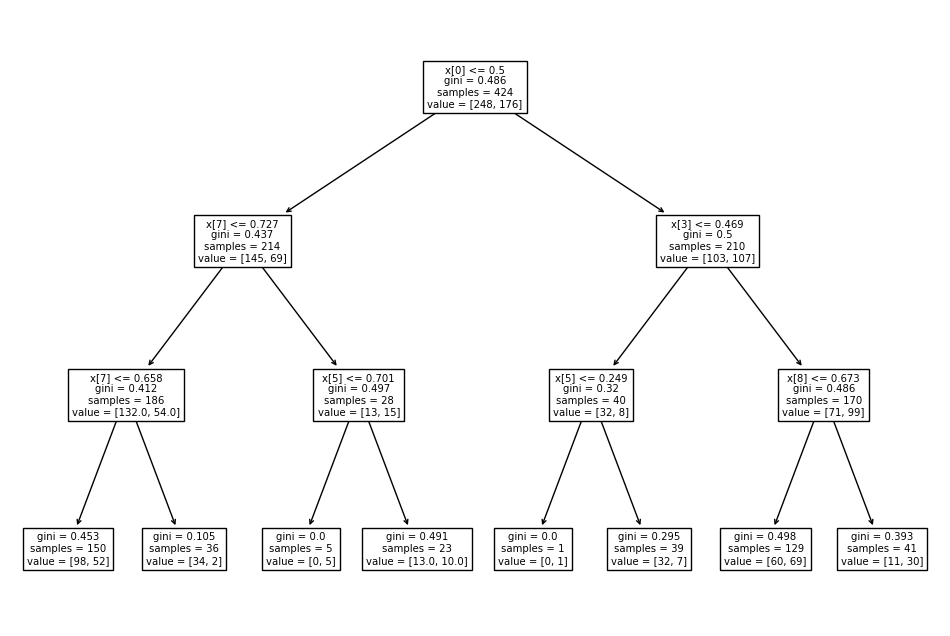

In [51]:
plt.figure(figsize=(12, 8))
plot_tree(clf)